# Each sample has a slightly different interface thermal coupling

In [183]:
%pylab notebook

from scipy.optimize import curve_fit

import sys, os, importlib, warnings, pandas as pd, seaborn as sns
warnings.filterwarnings("ignore")

sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation')
import hts_fitting as hts, default_figure_style as dfs, hts_fitfunctions as ff
for lib in [hts, dfs, ff]:
    importlib.reload(lib)


#################################
########## Load data ############
#################################

cols = [0, 1, 9, 10, 12, 13, 14, 19, 23, 25, 27, 29, 39, 41, 43, 45, 52, 53, 54, 55, 56, 57, 58, 59]
names = [
    'tapeid', 
    'anneal',
    'ibeam',
    'ibeam_std',
    'energy', 
    'power', 
    'powerError',
    'ic0',
    'icoff',
    'noff',
    'icon',
    'non',
    
    'tHTS_OFF',
    'tTAR_OFF',
    'tHTS_ON',
    'tTAR_ON',
    
    'tREBCO',
    'degradation',
    'degradationError',
    'suppression', 
    'suppressionError',
    'suppression_corrected',
    'suppressionError_corrected',
    'outlier' 
]
df = pd.read_excel(dfs.master, sheet_name='data', usecols=cols, names=names, skiprows=1)

#################################
########## Filter data ##########
#################################
#cut &= df.installation == 1

cut = df.tTAR_OFF < 20
cut &= (df.suppression != np.nan) & (df.suppression > 0) & (df.suppressionError > 0)
cut &= df.outlier != 1

data = df[cut]

print('\n\nTotal datapoints', data.energy.count())
for tapeid in data.tapeid.unique():
    print('\nDatapoints for', tapeid, data[data.tapeid==tapeid].energy.count())

for energy in data.energy.unique():
    print('\nDatapoints for', energy, data[data.energy==energy].energy.count())
df.columns

outputDirectory = '../figures/raw/'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Total datapoints 687

Datapoints for f33 68

Datapoints for f20 14

Datapoints for f34 9

Datapoints for f29 302

Datapoints for f23 2

Datapoints for f28 69

Datapoints for f37 223

Datapoints for 150 179

Datapoints for 800 138

Datapoints for 2400 132

Datapoints for 1200 238


## Send data to Nico

In [2]:
keep = ['tapeid', 'anneal', 'ibeam', 'ibeam_std', 'energy', 'power', 'powerError', 'tREBCO', 'tHTS_ON', 'tHTS_OFF', 'tTAR_ON', 'tTAR_OFF']
newNames = {
    'tapeid': 'tape',
    'anneal': 'anneal',
    'ibeam': 'ibeam',
    'ibeam_std': 'ibeam_std',
    'energy': 'energy',
    'power': 'power',
    'powerError': 'powerError',
    'tREBCO': 'tREBCO',
    'tHTS_ON': 'tTape_ON',
    'tHTS_OFF': 'tTape_OFF',
    'tTAR_ON': 'tTarget_ON',
    'tTAR_OFF': 'tTarget_OFF'
}
dataForNico = data[(data.tapeid == 'f28')][keep].rename(newNames)
dataForNico.to_excel('../data/fem/modelinput-f28.xlsx')

# With Nico's Thermal Model

<IPython.core.display.Javascript object>


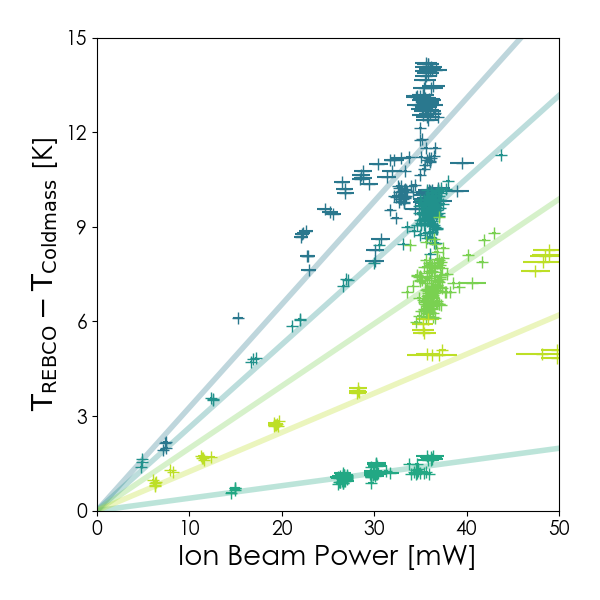

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fitfunction = ff.affine
xsmooth = np.linspace(0, 80, 1000)



# There are two sets for f29 and f37 because the first anneal changes the thermal coupling (response?) of the tape
alldata = []
allTapes = np.array(['f20', 'f23', 'f28', 'f29', 'f33', 'f34', 'f37'])
palette = sns.color_palette('viridis', 9)
for tape in allTapes:
    d = data[(data.tapeid == tape) & (data.tREBCO-data.tTAR_ON > 0) & (data.anneal == 1)]
    alldata.append(d)
    
    if (tape == 'f29')|(tape == 'f37'):
        d = data[(data.tapeid == tape) & (data.tREBCO-data.tTAR_ON > 0) & (data.anneal > 1)]
        alldata.append(d)

for i, d in enumerate(alldata):
    if d.tapeid.iloc[0] not in ['f20', 'f23', 'f28', 'f34']:
        x, ex = d.power, d.powerError
        y, ey = d.tREBCO-d.tTAR_ON, np.zeros_like(d.powerError)

        popt, pcov = curve_fit(ff.affine, x, y)

        ax.plot(xsmooth, ff.affine(xsmooth, *popt), color=palette[i], alpha=.3, linewidth=4)
        ax.errorbar(x, y, xerr=ex, linestyle='None', marker=m, markersize=8, color=palette[i])


ax.set_xlabel('Ion Beam Power [mW]')
ax.set_ylabel('$\mathrm{T_{REBCO} - T_{Cold mass}}$ [K]')
ax.set_xlim(0, 50)
ax.set_ylim(0, 15)
ax.set_yticks([0, 3, 6, 9, 12, 15])
fig.tight_layout()
plt.savefig(outputDirectory+'thermal-resistance.svg', format='svg', facecolor='white')

<IPython.core.display.Javascript object>


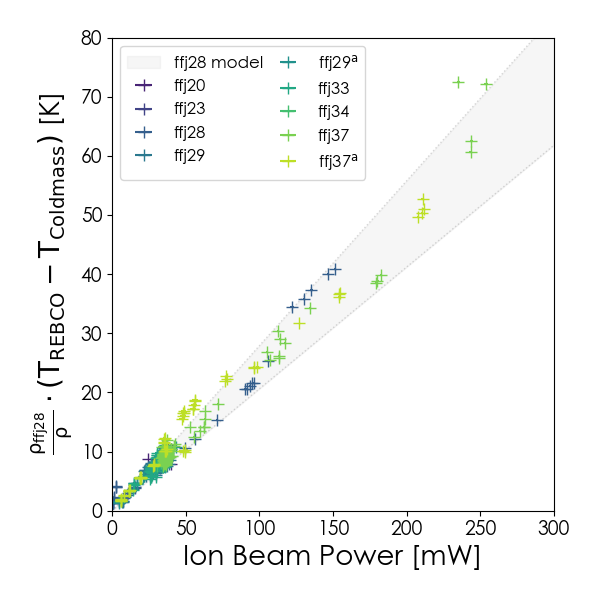

ffj28 thermal resistance 0.2525580531927326


In [212]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fitfunction = ff.affine
xsmooth = np.linspace(0, 300, 1000)
xx, yy, ii, ee, aa, tt, yn = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

rho0 = 0.2525580531927326 # interface thermal resistance for ffj28

# There are two sets for f29 and f37 because the first anneal changes the thermal coupling (response?) of the tape
alldata = []
allTapes = np.array(['f20', 'f23', 'f28', 'f29', 'f33', 'f34', 'f37'])
palette = sns.color_palette('viridis', 9)
for tape in allTapes:
    d = data[(data.tapeid == tape) & (data.tREBCO-data.tTAR_ON > 0) & (data.anneal == 1)]
    alldata.append(d)
    
    if (tape == 'f29')|(tape == 'f37'):
        d = data[(data.tapeid == tape) & (data.tREBCO-data.tTAR_ON > 0) & (data.anneal > 1)]
        alldata.append(d)

for i, d in enumerate(alldata):
    tape = d.tapeid.iloc[0]
    x, ex = d.power, d.powerError
    y, ey = d.tREBCO-d.tTAR_ON, np.zeros_like(d.powerError)

    popt, pcov = curve_fit(ff.affine, x, y)
    handles, labels = plt.gca().get_legend_handles_labels()
    label = tape.replace('f', 'ffj')
    if label in labels:
        label += '$\mathrm{^{a}}$'
        
    if tape == 'f28':
        print('ffj28 thermal resistance', popt[0])
        ax.errorbar(x, y, xerr=ex, linestyle='None', marker='+', markersize=8, color=palette[i], label=label)
    else:
        ax.errorbar(x, rho0*y/popt[0], xerr=ex, linestyle='None', marker='+', markersize=8, color=palette[i], label=label)
    xx = np.append(xx, x)
    yy = np.append(yy, rho0*y/popt[0])
    ee = np.append(ee, d.energy)
    ii = np.append(ii, d.index)
    tt = np.append(tt, d.tapeid)
    aa = np.append(aa, d.anneal)
    yni = []
    for ei in d.energy:
        if ei == 150:
            yni.append(1)
        else:
            yni.append(0)
    yn = np.append(yn, yni)
  



parentDirectory = '/Users/alexisdevitre/Desktop/1200keV/'
modelmin = pd.read_csv(parentDirectory+'f28_1200keV_deltaT_Apiezon=10um+Sensorpos=4.96mm.txt', names=['ibeam', 'tREBCO'], usecols=[0, 3], delim_whitespace=True, skiprows=5)
modelmax = pd.read_csv(parentDirectory+'f28_1200keV_deltaT_Apiezon=16um+Sensorpos=4.96mm.txt', names=['ibeam', 'tREBCO'], usecols=[0, 3], delim_whitespace=True, skiprows=5)

popt_min, _ = curve_fit(ff.affine, modelmin.ibeam*1200/1e3, modelmin.tREBCO)
popt_max, _ = curve_fit(ff.affine, modelmax.ibeam*1200/1e3, modelmax.tREBCO)
    

ax.fill_between(xsmooth, ff.affine(xsmooth, *popt_min), ff.affine(xsmooth, *popt_max), color='lightgray', alpha=.2, label='ffj28 model')
ax.plot(xsmooth, ff.affine(xsmooth, *popt_min), linewidth=1, linestyle=':', color='gray', alpha=.3)
ax.plot(xsmooth, ff.affine(xsmooth, *popt_max), linewidth=1, linestyle=':', color='gray', alpha=.3)



ax.legend(loc='upper left', ncols=2, columnspacing=.5)
ax.set_xlabel('Ion Beam Power [mW]')
ax.set_ylabel(r'$\mathrm{\frac{\rho_{ffj28}}{\rho} \cdot (T_{REBCO} - T_{Cold mass})}$ [K]') #\mathrm{\rho}$')# / \rho }$ [K]')
ax.set_xlim(0, 300)
ax.set_ylim(0, 80)
fig.tight_layout()
plt.savefig(outputDirectory+'thermal-resistance-normalized.svg', format='svg', facecolor='white')

<IPython.core.display.Javascript object>


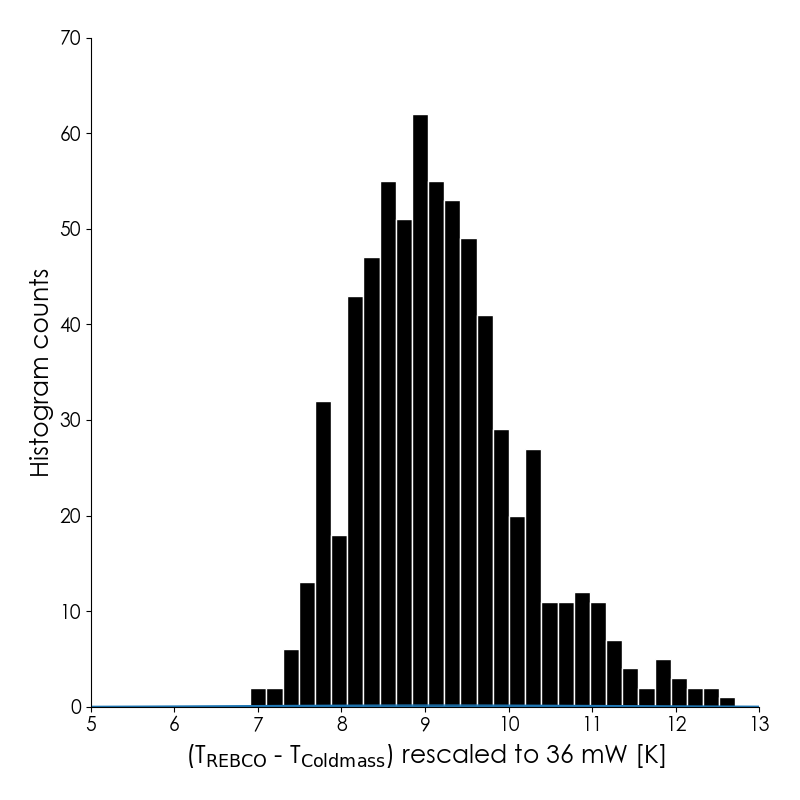

In [147]:
#supxlabel, supylabel

fig, ax = plt.subplots(1, 1, figsize=(8, 8), sharex=True, sharey=True)
ax.set_xlabel('(T$\mathrm{_{REBCO}}$ - T$\mathrm{_{Coldmass}}$) rescaled to 36 mW [K]', fontsize=18)
ax.set_ylabel('Histogram counts', fontsize=18)

nbins, density = 30, False
ss = 36*yy/xx

ssNoDamage = ss[ee == 150]
ssDamage = ss[ee != 150]

cut =  (ss < 50) #(13 < ss) & (ss < 50)# ss < 50 # 

ax.hist(ss[cut], bins=nbins, density=density, edgecolor='white', facecolor='k', label='All energies: {} counts'.format(len(yy)))

xsmooth = np.linspace(0, 20, 10000)
ysmooth = ff.gaussian(xsmooth, 120, 9, 0.8)
#ax.plot(xsmooth, ysmooth, color='b', linewidth=4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim(5, 13)
ax.set_ylim(0, 70)

fig.tight_layout()
plt.savefig(outputDirectory+'histogram.svg', format='svg', facecolor='white')

df = pd.DataFrame({'power': xx[cut], 's': yy[cut], 's36': ss[cut]})
df.to_excel('../data/histograms/histogram.xlsx', index=False)





dsnames = ['all', 'noDisplacements', 'displacements']
cuts = [(ss < 50), (ee == 150), (ee != 150)]
for cut, dsname in zip(cuts, dsnames):
    df = pd.DataFrame({'dT': ss[cut], 'power': xx[cut], 'energy': ee[cut], 'tape': tt[cut], 'anneal': aa[cut], 'yn150keV': yn[cut], 'index': ii[cut]})
    df.to_excel('../data/histograms/{}.xlsx'.format(dsname, index=False))

<IPython.core.display.Javascript object>


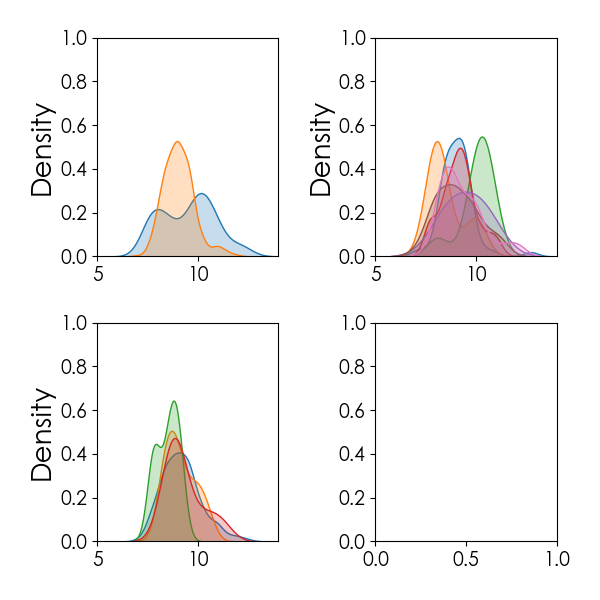

In [182]:
fig, axes = subplots(2, 2)
axes = axes.flatten()

cut = (ss < 50) # Get rid of the strange low power points


sns.kdeplot(ss[cut & (data.energy == 150)], shade=True, ax=axes[0], common_norm=True)
sns.kdeplot(ss[cut & (data.energy != 150)], shade=True, ax=axes[0], common_norm=True)
axes[0].set_xlim(5, 14)
axes[0].set_ylim(0, 1)
    
for tape in data.tapeid.unique():
    sns.kdeplot(ss[cut & (data.tapeid == tape)], shade=True, ax=axes[1])
    axes[1].set_xlim(5, 14)
    axes[1].set_ylim(0, 1)

powers = np.linspace(data.power.min(), data.power.max(), 5)
for p0, p1 in zip(powers[:-1], powers[1:]):
    sns.kdeplot(ss[cut & (p0 <= data.power) & (data.power <= p1)], shade=True, ax=axes[2])
    axes[2].set_xlim(5, 14)
    axes[2].set_ylim(0, 1)

fig.tight_layout()

In [ ]:
Voigt, Lorentzian

In [118]:
from scipy import stats
d = ss[ss<50]
shapiro_test = stats.shapiro(d)
print(shapiro_test.pvalue)

anderson_test = stats.anderson(d)
print(anderson_test.critical_values)
print(anderson_test.significance_level)

dagostino_test = stats.normaltest(d)
print(dagostino_test.pvalue)

1.0917221571205005e-09
[0.573 0.652 0.782 0.913 1.086]
[15.  10.   5.   2.5  1. ]
3.0021982189978375e-11


In [102]:
# Perform the Shapiro-Wilk test

print(f"Shapiro-Wilk test statistic: {shapiro_test.statistic}")
print(f"Shapiro-Wilk test p-value: {shapiro_test.pvalue}")

# Plot histogram
plt.hist(data, bins=30, alpha=0.7, color='blue', edgecolor='black')

# Add a title with the test results
plt.title(f'Histogram of Data\nShapiro-Wilk p-value: {shapiro_test.pvalue:.4f}')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

NameError: name 'stats' is not defined

In [ ]:
Make a histo for different beam powers
Make histos for beam energies
Low beam current points are probably within the resolution of Ic

# What's in the tail of the distribution

### First there are a few points pertaining to the low power range of f28, that produce a very high temperature rise when rescale to 36 mW

<IPython.core.display.Javascript object>


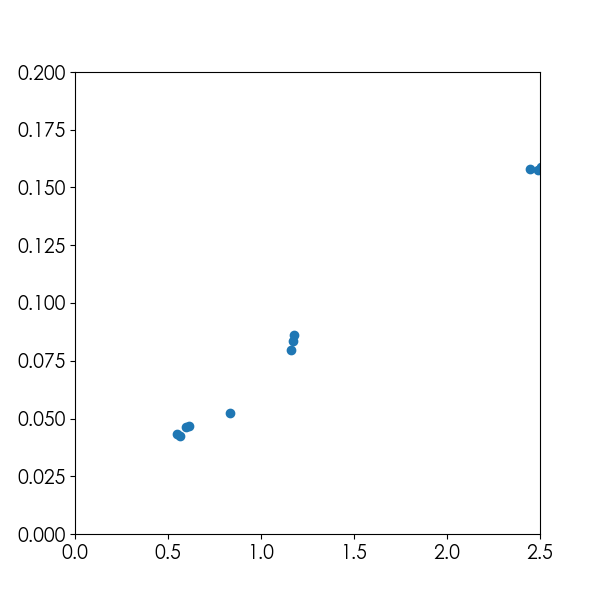

(0.0, 0.2)

In [20]:
highpoints = [460., 461., 462., 463., 464., 465., 466., 467., 468., 469., 470.]
highpoints = pd.read_excel(dfs.master, sheet_name='data', usecols=cols, names=names, skiprows=1).iloc[highpoints]
highpoints

fig, ax = plt.subplots()

x, y = highpoints.power, highpoints.suppression
ax.plot(x, y, marker='o', markersize=6, linestyle='None')

ax.set_xlim(0, 2.5)
ax.set_ylim(0, 0.2)

### Then there are points which don't produce excessively high temperatures but seem to be part of a high temperature tail

In [17]:
hightail = [ 69., 151., 157., 161., 412., 413., 4., 5., 21., 22., 23., 50., 490., 543., 549., 659., 660., 661., 662., 663., 664., 665., 666., 667., 668., 688., 689., 690., 691., 692., 699., 701.]
hightail = pd.read_excel(dfs.master, sheet_name='data', usecols=cols, names=names, skiprows=1).iloc[hightail]
hightail

,tapeid,anneal,energy,power,powerError,ic0,icoff,icon,tTAR_OFF,tTAR_ON,tREBCO,degradation,degradationError,suppression,suppressionError,suppression_corrected,suppressionError_corrected,outlier
69,f20,1,800,24.700000,0.256192,34.175467,32.031980,26.249793,19.14545,19.20847,27.773018,0.937280,7.142760e-08,0.180513,5.493237e-08,0.176658,0,0
151,f29,1,150,35.622827,1.190181,35.103696,35.103696,24.433235,19.62744,19.65845,33.855749,1.000000,7.597168e-08,0.303970,5.412613e-08,0.302962,0,0
157,f29,1,150,15.250197,0.512911,35.103696,35.103696,30.423744,19.62744,19.64807,25.772265,1.000000,7.597168e-08,0.133318,5.648960e-08,0.132840,0,0
161,f29,1,150,7.404721,0.247756,35.103696,35.103696,32.279830,19.62744,19.68140,23.432442,1.000000,7.597168e-08,0.080444,6.036577e-08,0.080149,0,0
412,f29,4,2400,4.861580,0.101947,35.103696,4.175563,3.939347,19.78919,19.76325,21.316901,0.118949,1.561091e-08,0.056571,1.599749e-07,0.031154,0,0
413,f29,4,2400,4.942022,0.095561,35.103696,4.176963,3.928954,19.74246,19.75713,21.383700,0.118989,1.563246e-08,0.059375,1.595247e-07,0.032721,0,0
4,f33,1,150,14.893000,0.497282,33.067613,5.133635,5.022627,19.81361,19.80779,20.543613,0.155247,2.070521e-08,0.021624,1.647072e-07,0.012921,0,0
5,f33,1,150,14.951667,0.504948,33.067613,5.133635,5.041142,19.81361,19.73106,20.452420,0.155247,2.070521e-08,0.018017,1.651212e-07,0.010760,0,0
21,f33,1,150,30.239167,1.008078,33.067613,5.005277,4.748597,19.74654,19.81231,21.291852,0.151365,2.585493e-08,0.051282,1.891465e-07,0.030566,0,0
22,f33,1,150,30.239167,1.008078,33.067613,5.005277,4.751652,19.74654,19.75656,21.276221,0.151365,2.585493e-08,0.050671,1.892378e-07,0.030199,0,0


<IPython.core.display.Javascript object>


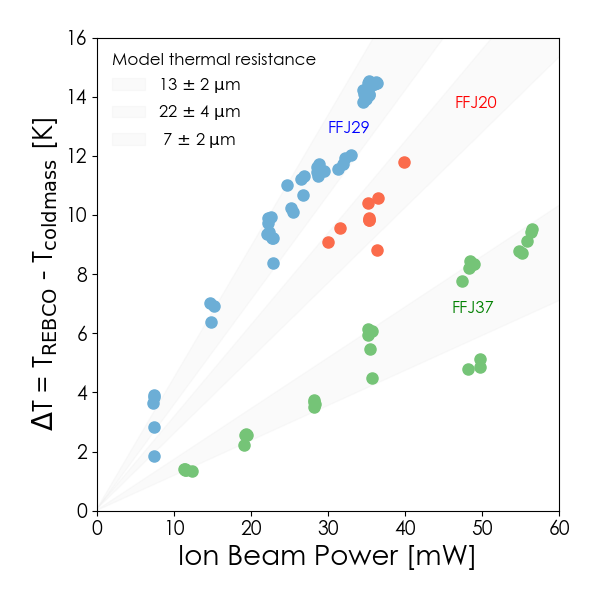

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fitfunction = ff.affine

dataf20 = data[(df.tapeid == 'f20') & (data.dtOn > 0) & (data.eBeam == 150)]
dataf29 = data[(df.tapeid == 'f29') & (data.dtOn > 0) & (data.eBeam == 150)]
dataf37 = data[(df.tapeid == 'f37') & (data.dtOn > 0) & (data.eBeam == 150)]

# plot the thermal model envelope
parentDirectory = '../data/fem/latest/Data_txt_Final/'
f20min = pd.read_csv(parentDirectory+'f20/150keV/f20_150keV_deltaT_Apiezon=11um+Sensorpos=4.96mm.txt', names=['ibeam', 'tREBCO'], usecols=[0, 3], delim_whitespace=True, skiprows=5)
f20max = pd.read_csv(parentDirectory+'f20/150keV/f20_150keV_deltaT_Apiezon=15um+Sensorpos=4.96mm.txt', names=['ibeam', 'tREBCO'], usecols=[0, 3], delim_whitespace=True, skiprows=5)

f29min = pd.read_csv(parentDirectory+'f29/150keV/f29_150keV_deltaT_Apiezon=18um+Sensorpos=4.96mm.txt', names=['ibeam', 'tREBCO'], usecols=[0, 3], delim_whitespace=True, skiprows=5)
f29max = pd.read_csv(parentDirectory+'f29/150keV/f29_150keV_deltaT_Apiezon=26um+Sensorpos=4.96mm.txt', names=['ibeam', 'tREBCO'], usecols=[0, 3], delim_whitespace=True, skiprows=5)

f37min = pd.read_csv(parentDirectory+'f37/150keV/f37_150keV_deltaT_Apiezon=5um+Sensorpos=4.96mm.txt', names=['ibeam', 'tREBCO'], usecols=[0, 3], delim_whitespace=True, skiprows=5)
f37max = pd.read_csv(parentDirectory+'f37/150keV/f37_150keV_deltaT_Apiezon=9um+Sensorpos=4.96mm.txt', names=['ibeam', 'tREBCO'], usecols=[0, 3], delim_whitespace=True, skiprows=5)

xsmooth = np.linspace(0, 250, 10000)
palette = sns.color_palette("rocket", n_colors=3)
for d, dpalette, modelmin, modelmax, c, nominalThickness, pmThickness in zip([dataf20, dataf29, dataf37], ['Reds_r', 'Blues_r', 'Greens_r'], [f20min, f29min, f37min], [f20max, f29max, f37max], ['r', 'b', 'g'], [13, 22, 7], [2, 4, 2]):
    popt_min, pcov_min = curve_fit(ff.linear, modelmin.ibeam*150/1e3, modelmin.tREBCO)
    popt_max, pcov_max = curve_fit(ff.linear, modelmax.ibeam*150/1e3, modelmax.tREBCO)
    ax.fill_between(xsmooth, ff.linear(xsmooth, *popt_min), ff.linear(xsmooth, *popt_max), color='lightgray', alpha=.1, label='{:2.0f}'.format(nominalThickness)+' $\pm$ '+'{:1.0f}'.format(pmThickness)+' $\mathrm{\mu}$m')
    
    x, ex = d.power, d.powerError
    y, ey = d.dtOn, np.zeros_like(x)
    

    nsegments = 1
    pintervals = np.linspace(0, 1, nsegments)
    for p, c in zip(pintervals, sns.color_palette(dpalette, len(pintervals))):
        cut = (p <= d.degradation) & (d.degradation <= p+1/nsegments)
        ax.plot(x[cut], y[cut], linestyle='None', marker='o', color=c, alpha=1)
    
ax.text(29.9, 12.8, 'FFJ29', color='b', fontsize=12)
ax.text(46.4, 13.6, 'FFJ20', color='r', fontsize=12)
ax.text(46, 6.7, 'FFJ37', color='g', fontsize=12)

ax.set_ylabel('$\Delta$T = T$_\mathrm{REBCO}$ - T$_\mathrm{cold mass}$ [K]')
ax.set_xlabel('Ion Beam Power [mW]')
ax.set_ylim(0, 16)
ax.set_xlim(0, 60)
ax.legend(title='Model thermal resistance', loc='upper left', alignment='left', frameon=False)

fig.tight_layout()

ax.set_rasterized(True)
plt.savefig(outputDirectory+'figure06-resistance.svg', format='svg', facecolor='white')